In [3]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [4]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
responses = []
with open('banki_responses.json', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:28, 6986.90it/s]


## Домашнее задание по NLP # 1 [100 баллов]¶

#### Классификация по тональности

Задача: классифицировать по тональности отзывы на банки (banki.ru).

Данные: тексты отзывов, доп. информация, оценка тональности по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

In [6]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

### Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм
    * существительных


1. Постройте кривые Ципфа и Хипса
2. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 
Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и 
биграмы для положительных отзывов (с оценкой 5) и отрицательных (с оценкой 1)

In [7]:
data = pd.DataFrame.from_dict(responses)
data = data.dropna()

In [68]:
# посмотрим реестр городов
from fuzzywuzzy import process
city = data.city.sort_values().unique()
city = list(process.dedupe(city))
city[3000:5500]

array(['г. г. Геленджик с.Дивноморское', 'г. г. Горно-Алтайск',
       'г. г. Долгопрудный', 'г. г. Домодедово', 'г. г. Ейск',
       'г. г. Екатеринбург', 'г. г. Железнодорожный', 'г. г. Жуковский',
       'г. г. Заполярный Мурманская область (Мурманск)',
       'г. г. Зеленоград', 'г. г. Иванново', 'г. г. Иркутск',
       'г. г. Калачинск', 'г. г. Калининград', 'г. г. Калуга',
       'г. г. Кашин, Тверская область', 'г. г. Кашира',
       'г. г. Киров, Кировская область', 'г. г. Кировск',
       'г. г. Климовск', 'г. г. Кодинск', 'г. г. Комсомольск-на Амуре',
       'г. г. Кореновск', 'г. г. Королев, Московская обл.',
       'г. г. Кострома', 'г. г. Красноармейск', 'г. г. Красногорск, МО',
       'г. г. Краснодар', 'г. г. Красноярск', 'г. г. Кумертау',
       'г. г. Лебедянь', 'г. г. Липецк', 'г. г. Лобня',
       'г. г. Лобня, Московской области', 'г. г. Люберцы',
       'г. г. Люберцы, Московская оласть', 'г. г. МОСКВА', 'г. г. Миасс',
       'г. г. Минеральные Воды', 'г. г. Мирный

#### Максимально сведем названия городов к единому формату

In [210]:
def str_split (row):
    name = row['city'].split(',')[0].split(' ')
    
    if len(name) > 1:
        
        if name[1] == 'г.' or name[1] == 'город':
            
            name = name[2]
        
        elif name[1][:2] == 'г.':
        
            name = name[1][2:]
            
        else:
            name = name[1]
    else:
        name = name[0]
    
    return name.lower()


In [211]:
data['city_short'] = data.apply(str_split, axis=1)

In [303]:
city_list = list(data['city_short'].value_counts()[:150].keys())
city_list

['москва',
 'санкт-петербург',
 'прочие',
 'екатеринбург',
 'нижний',
 'новосибирск',
 'самара',
 'ростов-на-дону',
 'казань',
 'челябинск',
 'уфа',
 'краснодар',
 'воронеж',
 'красноярск',
 'пермь',
 'волгоград',
 'саратов',
 'омск',
 'калининград',
 'хабаровск',
 'иркутск',
 'владивосток',
 'тюмень',
 'ярославль',
 'тула',
 'рязань',
 'барнаул',
 'томск',
 'ульяновск',
 'тверь',
 'спб',
 'ижевск',
 'иваново',
 'тольятти',
 'магнитогорск',
 'липецк',
 'пенза',
 'мытищи',
 'оренбург',
 'сочи',
 'мурманск',
 'ставрополь',
 'чебоксары',
 'балашиха',
 'владимир',
 'белгород',
 'подольск',
 'курск',
 'калуга',
 'королев',
 'архангельск',
 'люберцы',
 'кемерово',
 'химки',
 'набережные',
 'брянск',
 'новокузнецк',
 'астрахань',
 'санкт',
 'вологда',
 'одинцово',
 'киров',
 'таганрог',
 'петрозаводск',
 'раменское',
 'орел',
 'смоленск',
 'сергиев',
 'тамбов',
 'щелково',
 'новороссийск',
 'великий',
 'череповец',
 'железнодорожный',
 'жуковский',
 'красногорск',
 'сургут',
 'волжский',
 'зе

In [212]:
def big_city (row):

    if row['city_short'] in city_list:
        
        name = row['city_short']
    else:
        name = 'прочие'
    return name

In [213]:
data['city_short'] = data.apply(big_city, axis=1)

#### Посчитаем количество отзывов в разных городах и на разные банки

In [214]:
data_gr = data.groupby(['city', 'bank_name'])

In [215]:
data_gr.groups

{('moscow', '2Т Банк'): Int64Index([112725], dtype='int64'),
 ('moscow', 'АМТ Банк'): Int64Index([134330, 134346], dtype='int64'),
 ('moscow', 'Альфа-Банк'): Int64Index([71046, 94529, 124813], dtype='int64'),
 ('moscow', 'БИНБАНК кредитные карты'): Int64Index([111926], dtype='int64'),
 ('moscow', 'ВТБ 24'): Int64Index([131176], dtype='int64'),
 ('moscow', 'Витас Банк'): Int64Index([138217], dtype='int64'),
 ('moscow', 'МТС Банк'): Int64Index([73245, 109437], dtype='int64'),
 ('moscow', 'Мастер-Банк'): Int64Index([125741], dtype='int64'),
 ('moscow', 'Московский Кредитный Банк'): Int64Index([77227], dtype='int64'),
 ('moscow', 'Московский Областной Банк'): Int64Index([115522], dtype='int64'),
 ('moscow', 'Нордеа Банк'): Int64Index([124075], dtype='int64'),
 ('moscow', 'ОТП Банк'): Int64Index([123608], dtype='int64'),
 ('moscow', 'Океан Банк'): Int64Index([130691], dtype='int64'),
 ('moscow', 'Райффайзенбанк'): Int64Index([83474], dtype='int64'),
 ('moscow', 'Ренессанс Кредит'): Int64Ind

In [308]:
df = data_gr.count()['text']
df

city_short  bank_name              
moscow      2Т Банк                    1
            АМТ Банк                   2
            Альфа-Банк                 3
            БИНБАНК кредитные карты    1
            ВТБ 24                     1
                                      ..
ярославль   Экспобанк                  1
            Югра                       5
            ЮниКредит Банк             1
            Яндекс.Деньги              1
            Ярославич                  1
Name: text, Length: 6098, dtype: int64

In [322]:
df_city_bank = (pd.concat([df.to_frame(),
           df.sum(level=0).to_frame()
                 .assign(bank_name= "1_TOTAL")
                 .set_index('bank_name', append=True)],axis=0)
  .sort_index())
#df_city_bank.head(30)
df_city_bank.reset_index().sort_values('text', ascending=False).head(30)

,city_short,bank_name,text
2306,москва,1_TOTAL,33571
4568,санкт-петербург,1_TOTAL,8281
3735,прочие,1_TOTAL,5134
2594,москва,Сбербанк России,4773
2331,москва,Альфа-Банк,2105
2580,москва,Русский Стандарт,1709
3898,прочие,Сбербанк России,1676
2374,москва,ВТБ 24,1578
4722,санкт-петербург,Сбербанк России,1430
2491,москва,Московский Кредитный Банк,1412


#### Построим гистограмы длин отзывов в символах и в словах

In [48]:
data.text.iloc[0]

'Также как и многие давний клиент банка, был доволен в высшей степени. Сколько друзей и знакомых привел - даже не сосчитать. Большинство сотрудников моей компании перешли на зарплатный проект в Тинькофф. Практически все друзья завели себе карты и вклады. Но то, что творится в последнее время просто шокирует меня: 1) "Унификация" вкладов. В страшном сне не могло присниться, что могут снизить проценты на пополнение вклада (с 18 до 13%). Ответ по этому пункту читал. Могли бы тогда разрешить беспроцентно закрыть вклады, которые были открыты хотя бы в апреле перед сильным снижением. В декабре поверил банку и не стал открывать в других банках под более выгодные проценты (Совкомбанк, к примеру, не менее надежный банк, давал 25%, то есть 22,637 с учётом налога)..\xa0 2) Заметил, что из отзывов удаляют "неугодные" комментарии, касающиеся понижения ставок и ответы представителей банка полугодовой давности о недопустимости снижения ставки на пополнение (с портала вопрос-ответ информация также был

In [428]:
def split_word (row):

    text = row['text']
    count = len(text.split())
        
    return count

In [431]:
from nltk.tokenize import sent_tokenize, word_tokenize
import re

def tokenize (row):
    
    regex = re.compile("[А-Яа-яЁё]+")
    
    text = row['text']
    list_words = word_tokenize(" ".join(regex.findall(text)))
    count_token = len(list_words)
        
    return count_token

In [432]:
data['count_word_slash'] = data.apply(split_word, axis=1)
data['count_word_token'] = data.apply(tokenize, axis=1)
data['count_sim'] = data.apply(lambda x: len(str(x['text'])), axis=1)

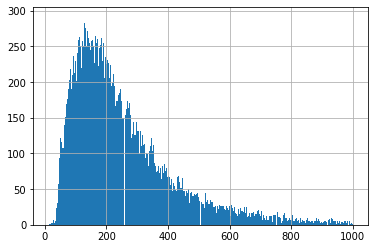

In [433]:
# длина отзывов в словах по пробелам
data.count_word_slash.hist(bins=1000, range=(12, 1000))

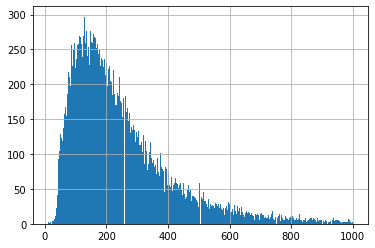

In [434]:
# длина отзывов в словах без учета пунктуации и с применением NLTK
data.count_word_token.hist(bins=1000, range=(12, 1000))

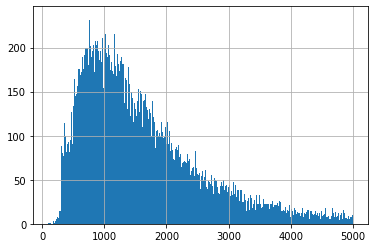

In [419]:
# длина отзывов в символах
data.count_sim.hist(bins=1000, range=(100, 5000))

#### Найдем 10 самых частых: слов, слов без стоп-слов, лемм, существительных

In [8]:
comments = list(data.text)

In [9]:
from ufal.udpipe import Model, Pipeline
from tqdm import tqdm_notebook as tqdm

In [10]:
model = Model.load("russian-ud-2.0-170801.udpipe") # path to the model

In [ ]:
sents = []
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')

for i in tqdm(comments, total = len(comments)):
    parsed = pipeline.process(i)
    sents.append(parsed)
sents

In [31]:
f = open('xyz.txt','w')
for index in sents:
    f.write(index)
f.close()

In [37]:
print(sents[0])

# newdoc
# newpar
# sent_id = 1
# text = Также как и многие давний клиент банка, был доволен в высшей степени.
1	Также	ТАКЖЕ	CCONJ	CC	_	2	cc:preconj	_	_
2	как	КАК	ADP	IN	_	6	case	_	_
3	и	И	PART	UH	_	6	discourse	_	_
4	многие	МНОГИЙ	ADJ	JJL	Animacy=Inan|Case=Nom|Number=Plur	6	amod	_	_
5	давний	давний	ADJ	JJL	Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing	6	amod	_	_
6	клиент	клиент	NOUN	NN	Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing	10	obl	_	_
7	банка	БАНК	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing	6	nmod	_	SpaceAfter=No
8	,	,	PUNCT	,	_	6	punct	_	_
9	был	БЫТЬ	AUX	VBC	Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	10	aux:pass	_	_
10	доволен	доволен	VERB	VBNH	Animacy=Anim|Aspect=Perf|Case=Nom|Gender=Masc|Number=Sing|Tense=Past|Variant=Short|VerbForm=Part|Voice=Pass	0	root	_	_
11	в	В	ADP	IN	_	13	case	_	_
12	высшей	ВЫСШИЙ	ADJ	JJS	Animacy=Inan|Case=Dat|Degree=Sup|Gender=Fem|Number=Sing	13	amod	_	_
13	степени	СТЕПЕНЬ	NOUN	NN	Animacy=Inan|Case=Dat|Gender=Fem|Numb

In [38]:
from conllu import parse

In [39]:
sentences = parse(sents[0])
sentence = sentences[0]
sentence[0]

{'id': 1,
 'form': 'Также',
 'lemma': 'ТАКЖЕ',
 'upos': 'CCONJ',
 'xpos': 'CC',
 'feats': None,
 'head': 2,
 'deprel': 'cc:preconj',
 'deps': None,
 'misc': None}

In [41]:
except_ = ['ADP', 'PUNCT', 'CCONJ', 'PRON', 'NUM', 'PART']
words = []
lemm = []
noun = []
all_list = []
s_list = []

for i in tqdm(sents, total = len(sents)):
    sentences = parse(i)
    s_list = []
    words = []
    lemm = []
    noun = []
    
    for sentence in sentences:

        for i in sentence:
            if i['upos'] not in except_:
                words.append(i['form'].lower())
                lemm.append(i['lemma'].lower())
                if i['upos'] == 'NOUN':
                    noun.append(i['lemma'].lower())
                else:
                    noun.append('-')
    s_list.append(words)
    s_list.append(lemm)
    s_list.append(noun)
    all_list.append(s_list)

all_list[1]

[['открыт',
  'вклад',
  'счет',
  'usd',
  'плюс',
  'есть',
  'зарплатная',
  'карта',
  'рублях',
  'сегодня',
  'пришел',
  'указанное',
  'отделение',
  'целью',
  'пополнить',
  'долларовый',
  'счёт',
  'usd',
  'дал',
  'операционисту',
  'паспорт',
  'зарплатную',
  'карту',
  'т',
  'окошке',
  'написано',
  'приготовьте',
  'карту',
  'подтверждения',
  'операции',
  'что',
  'то',
  'подобное',
  'прошлый',
  'раз',
  'потребовали',
  'сказал',
  'что',
  'нужно',
  'положить',
  'деньги',
  'долларовый',
  'счет',
  'операционист',
  'всё',
  'взяла',
  'что',
  'то',
  'делала',
  'крутила',
  'вертела',
  'вставила',
  'карту',
  'терминал',
  'сказала',
  'введите',
  'пин',
  'ввёл',
  'пин',
  'получил',
  'ответ',
  'чек',
  'где',
  'было',
  'написано',
  'что',
  'доллары',
  'были',
  'внесены',
  'счёт',
  'карты',
  'рублях',
  'вопрос',
  'банку',
  '№',
  'риторический',
  'понимаю',
  'нужно',
  'быть',
  'чтобы',
  'сознательно',
  'проводить',
  'такие',
 

In [42]:
frame = pd.DataFrame(all_list)
frame = frame.rename({0: 'form', 1: 'lemma', 2: 'noun'}, axis='columns')
frame.head()

,form,lemma,noun
0,"[многие, давний, клиент, банка, был, доволен, ...","[многий, давний, клиент, банк, быть, доволен, ...","[-, -, клиент, банк, -, -, -, степень, друг, -..."
1,"[открыт, вклад, счет, usd, плюс, есть, зарплат...","[открыть, вклад, счет, usd, плюс, быть, зарпла...","[-, вклад, счет, usd, -, -, -, карта, рублях, ..."
2,"[времени, вчера, поступило, смс, уведомление, ...","[время, вчера, поступило, смс, уведомление, чт...","[время, -, -, -, уведомление, -, банк, -, -, п..."
3,"[г, часов, пришел, указанный, офис, намерением...","[г, час, прийти, указанный, офис, намерением, ...","[г, час, -, -, офис, намерением, -, вклад, -, ..."
4,"[оплаты, коммунальных, платежей, пользуюсь, пл...","[оплата, коммунальных, платежей, пользуюсь, пл...","[оплата, -, платежей, -, -, карта, сайт, банк,..."


In [43]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

print(mystopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [44]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return [token for token in text if not token in mystopwords]
    except:
        return ""

In [45]:
frame['minus_stop'] = frame.form.apply(remove_stopwords)

In [46]:
frame['minus_stop_lemm'] = frame.lemma.apply(remove_stopwords)
frame.head()

,form,lemma,noun,minus_stop,minus_stop_lemm
0,"[многие, давний, клиент, банка, был, доволен, ...","[многий, давний, клиент, банк, быть, доволен, ...","[-, -, клиент, банк, -, -, -, степень, друг, -...","[многие, давний, клиент, банка, доволен, высше...","[многий, давний, клиент, банк, доволен, высший..."
1,"[открыт, вклад, счет, usd, плюс, есть, зарплат...","[открыть, вклад, счет, usd, плюс, быть, зарпла...","[-, вклад, счет, usd, -, -, -, карта, рублях, ...","[открыт, вклад, счет, usd, плюс, зарплатная, к...","[открыть, вклад, счет, usd, плюс, зарплатная, ..."
2,"[времени, вчера, поступило, смс, уведомление, ...","[время, вчера, поступило, смс, уведомление, чт...","[время, -, -, -, уведомление, -, банк, -, -, п...","[времени, вчера, поступило, смс, уведомление, ...","[время, вчера, поступило, смс, уведомление, ба..."
3,"[г, часов, пришел, указанный, офис, намерением...","[г, час, прийти, указанный, офис, намерением, ...","[г, час, -, -, офис, намерением, -, вклад, -, ...","[г, часов, пришел, указанный, офис, намерением...","[г, час, прийти, указанный, офис, намерением, ..."
4,"[оплаты, коммунальных, платежей, пользуюсь, пл...","[оплата, коммунальных, платежей, пользуюсь, пл...","[оплата, -, платежей, -, -, карта, сайт, банк,...","[оплаты, коммунальных, платежей, пользуюсь, пл...","[оплата, коммунальных, платежей, пользуюсь, пл..."


In [47]:
from collections import Counter
import itertools

In [48]:
# 10 самых частых слов
cnt_form = Counter(list(itertools.chain(*frame.form.values)))
cnt_form.most_common(10)

[('что', 312485),
 ('банка', 152598),
 ('банк', 114842),
 ('так', 79365),
 ('то', 76230),
 ('деньги', 72829),
 ('было', 68701),
 ('карту', 61762),
 ('уже', 61485),
 ('все', 59121)]

In [49]:
# 10 самых частых слов без стоп слов
cnt_minus_stop = Counter(list(itertools.chain(*frame.minus_stop.values)))
cnt_minus_stop.most_common(10)

[('банка', 152598),
 ('банк', 114842),
 ('деньги', 72829),
 ('карту', 61762),
 ('карты', 57407),
 ('отделение', 42904),
 ('день', 42289),
 ('заявление', 41102),
 ('банке', 39940),
 ('кредит', 39924)]

In [50]:
# 10 самых частых лемм
cnt_lemm = Counter(list(itertools.chain(*frame.lemma.values)))
cnt_lemm.most_common(10)

[('что', 314858),
 ('банк', 268167),
 ('быть', 248706),
 ('карта', 176332),
 ('этот', 109077),
 ('день', 98882),
 ('деньги', 96148),
 ('отделение', 89855),
 ('весь', 89832),
 ('так', 79365)]

In [51]:
# 10 самых частых существительных
cnt_noun = Counter(list(itertools.chain(*frame.noun.values)))
cnt_noun.most_common(11)

[('-', 8210432),
 ('банк', 236365),
 ('карта', 173821),
 ('день', 97987),
 ('деньги', 94340),
 ('отделение', 89589),
 ('сотрудник', 61789),
 ('сумма', 55649),
 ('год', 54642),
 ('раз', 54499),
 ('время', 53803)]

#### Построим кривые Ципфа и Хипса

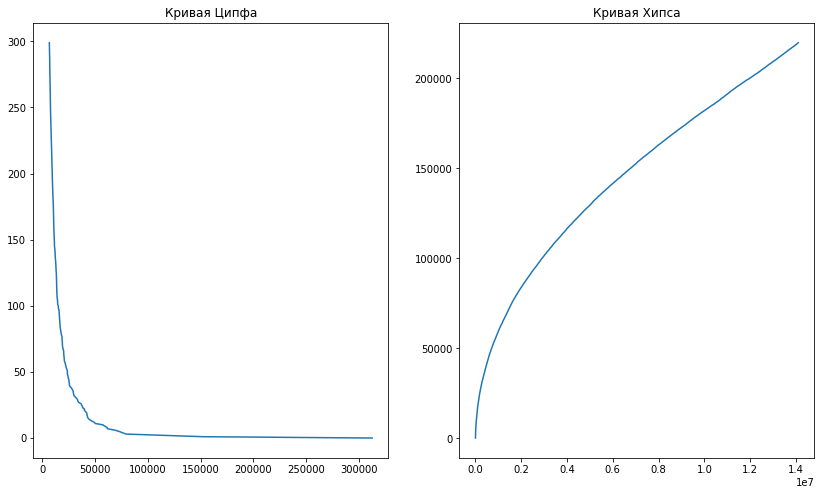

In [52]:
def plot_zipf_hips (fr):
    
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens = []

    for i in fr.values:
            cnt.update(list(i))
            n_types.append(len(cnt))
            n_tokens.append(np.sum(list(cnt.values())))

    freqs = list(cnt.values())
    freqs = sorted(freqs, reverse = True)
    
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    ax1.plot(freqs[:300], range(300))
    ax1.set_title('Кривая Ципфа')
    
    ax2.plot(n_tokens, n_types)
    plt.title('Кривая Хипса')
    
    fig.set_figheight(8)
    fig.set_figwidth(14)
    plt.show()

plot_zipf_hips(frame.form)

#### Ответим на следующие вопросы:
* какое слово встречается чаще, "сотрудник" или "клиент"?
* сколько раз встречается слова "мошенничество" и "доверие"?

In [53]:
print('Сотрудник - ', cnt_lemm['сотрудник'], 'Клиент - ', cnt_lemm['клиент'])
print('Мошенничество - ', cnt_lemm['мошенничество'],'Доверие - ', cnt_lemm['доверие'])

Сотрудник -  63062 Клиент -  28717
Мошенничество -  457 Доверие -  615


#### Используем меру  𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы:
* для положительных отзывов (с оценкой 5) 
* отрицательных (с оценкой 1)

In [54]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0


In [55]:
frame['rating_grade'] = data.rating_grade.reset_index()['rating_grade']

In [56]:
frame.head()

,form,lemma,noun,minus_stop,minus_stop_lemm,rating_grade
0,"[многие, давний, клиент, банка, был, доволен, ...","[многий, давний, клиент, банк, быть, доволен, ...","[-, -, клиент, банк, -, -, -, степень, друг, -...","[многие, давний, клиент, банка, доволен, высше...","[многий, давний, клиент, банк, доволен, высший...",2.0
1,"[открыт, вклад, счет, usd, плюс, есть, зарплат...","[открыть, вклад, счет, usd, плюс, быть, зарпла...","[-, вклад, счет, usd, -, -, -, карта, рублях, ...","[открыт, вклад, счет, usd, плюс, зарплатная, к...","[открыть, вклад, счет, usd, плюс, зарплатная, ...",1.0
2,"[времени, вчера, поступило, смс, уведомление, ...","[время, вчера, поступило, смс, уведомление, чт...","[время, -, -, -, уведомление, -, банк, -, -, п...","[времени, вчера, поступило, смс, уведомление, ...","[время, вчера, поступило, смс, уведомление, ба...",1.0
3,"[г, часов, пришел, указанный, офис, намерением...","[г, час, прийти, указанный, офис, намерением, ...","[г, час, -, -, офис, намерением, -, вклад, -, ...","[г, часов, пришел, указанный, офис, намерением...","[г, час, прийти, указанный, офис, намерением, ...",1.0
4,"[оплаты, коммунальных, платежей, пользуюсь, пл...","[оплата, коммунальных, платежей, пользуюсь, пл...","[оплата, -, платежей, -, -, карта, сайт, банк,...","[оплаты, коммунальных, платежей, пользуюсь, пл...","[оплата, коммунальных, платежей, пользуюсь, пл...",1.0


In [228]:
positive = frame[frame.rating_grade == 5]
negative = frame[frame.rating_grade == 1]

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [65]:
def tfidf(df):
    key_words = []
    
    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)

    tokens = list(df.minus_stop_lemm.values)
    tfidf_matrix =  tfidf.fit_transform([' '.join(token) for token in tokens])
    feature_names = tfidf.get_feature_names() 

    sorted_items=sort_coo(tfidf_matrix.tocoo())
    
    for index, score in sorted_items[:20]:
        key_words.append([feature_names[index],score])
    
    return key_words

In [66]:
tfidf(negative)

[['25d0', 0.8484752959461741],
 ['барклайс', 0.6994160365124794],
 ['юб', 0.6865027385527597],
 ['тыханская', 0.6835911207660947],
 ['d0', 0.678549175591125],
 ['noc', 0.665303745611495],
 ['казаться', 0.6572993508477851],
 ['дир', 0.6383051766881009],
 ['ргс', 0.6318465884153704],
 ['донбанк', 0.6315238746162308],
 ['мб', 0.6189299846585664],
 ['d0', 0.6181315444254536],
 ['равный равный', 0.6148143367386507],
 ['старик', 0.6108759242310735],
 ['ubank', 0.5881080460464505],
 ['птс', 0.5863587028457101],
 ['ms ms', 0.5761033859256727],
 ['вексель', 0.572798352673964],
 ['apr', 0.5652467574625623],
 ['d0', 0.5585667666499535]]

In [67]:
tfidf(positive)

[['пд', 0.512802172261007],
 ['маштакова анна', 0.4673879304088079],
 ['маштакова', 0.4673879304088079],
 ['рамиля', 0.46069393704772943],
 ['солнечногорск', 0.45399369378560944],
 ['семинар', 0.44614981079531163],
 ['полина', 0.4406939171169387],
 ['appstore', 0.44062882727951896],
 ['марюс', 0.4378433670619036],
 ['миля', 0.433592096636909],
 ['анни', 0.4319222061320443],
 ['гарантий', 0.42865631201537324],
 ['вэб', 0.42424209518504213],
 ['першинг', 0.4136367653538857],
 ['джиргал', 0.41308176988373774],
 ['щукинский', 0.40949232561650084],
 ['qiwi', 0.40555103640311535],
 ['райф банк', 0.40134556599834087],
 ['регулярная', 0.39751534235220215],
 ['тумбочки', 0.39671133906940276]]

## Часть 2. Тематическое моделирование [20/100]

1)
* Постройте несколько тематических моделей коллекции документов с разным числом тем. 
* Приведите примеры понятных (интерпретируемых) тем.

2)
* Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). 
* Можете ли вы их прокомментировать / объяснить?

In [80]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel
from gensim.models import ldamodel

In [87]:
#texts = [text.split() for text in data.text]
texts = list(frame.minus_stop_lemm.values)
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [88]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [89]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

CPU times: user 1min 46s, sys: 9.85 s, total: 1min 56s
Wall time: 1min 21s


In [156]:
#  тематические модели коллекции документов с разным числом тем
tem = lsi.show_topics(num_topics=50, num_words=10)
tem[1:6]

[(1,
  '-0.954*"*" + 0.108*"вклад" + -0.053*"№" + 0.051*"очередь" + -0.051*"номер" + -0.038*"сбербанк" + -0.037*"руб" + 0.035*"минута" + 0.034*"открыть" + 0.031*"очень"'),
 (2,
  '0.518*"вклад" + 0.249*"*" + 0.159*"очередь" + -0.154*"банкомат" + -0.150*"сбербанк" + -0.150*"заявление" + 0.141*"открыть" + -0.116*"карта" + 0.097*"минута" + 0.091*"открытие"'),
 (3,
  '0.461*"кредит" + -0.313*"карта" + 0.199*"договор" + -0.178*"банкомат" + -0.154*"сбербанк" + 0.140*"сумма" + 0.124*"страховки" + -0.122*"деньги" + 0.118*"погашения" + -0.117*"операция"'),
 (4,
  '0.404*"вклад" + -0.304*"карта" + 0.236*"банкомат" + 0.205*"деньги" + 0.164*"средство" + 0.154*"сумма" + -0.118*"заявку" + 0.116*"руб" + 0.115*"г" + 0.112*"выдал"'),
 (5,
  '0.356*"карта" + 0.227*"вклад" + -0.212*"банкомат" + 0.193*"комиссия" + -0.188*"очередь" + 0.137*"руб" + -0.125*"человек" + -0.117*"работать" + 0.110*"интернет" + -0.109*"минута"')]

In [ ]:
# примеры понятных (интерпретируемых) тем:
Долгое ожидание в очереди: '-0.954*"*" + 0.108*"вклад" + -0.053*"№" + 0.051*"очередь" + -0.051*"номер" + -0.038*"сбербанк" + -0.037*"руб" + 0.035*"минута" + 0.034*"открыть" + 0.031*"очень"'

In [91]:
%%time 
ldamodel = ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=30, id2word = dictionary, passes=20)

CPU times: user 1h 34s, sys: 5min 58s, total: 1h 6min 33s
Wall time: 34min 57s


In [92]:
ldamodel.print_topics(num_topics=5, num_words=10)

[(1,
  '0.003*"вал" + 0.003*"земляной" + 0.002*"нами" + 0.002*"пермь" + 0.002*"юрлицо" + 0.002*"физлицо" + 0.001*"посад" + 0.001*"сергиев" + 0.001*"базовый" + 0.001*"челны"'),
 (16,
  '0.010*"аб" + 0.003*"авангарда" + 0.002*"пропуск" + 0.002*"юнистрим" + 0.002*"вернадский" + 0.002*"садовой" + 0.002*"пробизнесбанк" + 0.001*"иваново" + 0.001*"маэстро" + 0.001*"перекресток"'),
 (13,
  '0.006*"ситифон" + 0.005*"рс" + 0.004*"недостаток" + 0.004*"подавал" + 0.003*"западный" + 0.003*"приятное" + 0.003*"сбера" + 0.003*"осень" + 0.002*"кредитка" + 0.002*"сдал"'),
 (9,
  '0.006*"брс" + 0.002*"клуб" + 0.001*"загранпаспорт" + 0.001*"ит" + 0.001*"калуга" + 0.001*"фмс" + 0.000*"кбк" + 0.000*"мобильной" + 0.000*"уфмс" + 0.000*"школа"'),
 (14,
  '0.002*"мб" + 0.001*"екатеринбурге" + 0.001*"копейку" + 0.000*"рублев" + 0.000*"лидерского" + 0.000*"одновременных" + 0.000*"обрабатывающая" + 0.000*"платформенный" + 0.000*"неприличная" + 0.000*"безвкусно"')]

In [174]:
# Поиск темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк).
from fuzzywuzzy import process
bank = ['сбер', 'втб', 'банк']
tem_bank = []

for i in tem:
    keys = [x.split('*')[1][1:-1] for x in i[1].split(' + ')]
    for ii in keys:
        if (ii[:4] in bank or ii[-4:] in bank or ii[:3] in bank) and ii != 'банкомат':
            tem_bank.append(i)
tem_bank

[(0,
  '0.205*"карта" + 0.124*"кредит" + 0.120*"деньги" + 0.108*"отделение" + 0.103*"заявление" + 0.100*"сумма" + 0.098*"вклад" + 0.096*"сбербанк" + 0.091*"счет" + 0.088*"день"'),
 (1,
  '-0.954*"*" + 0.108*"вклад" + -0.053*"№" + 0.051*"очередь" + -0.051*"номер" + -0.038*"сбербанк" + -0.037*"руб" + 0.035*"минута" + 0.034*"открыть" + 0.031*"очень"'),
 (2,
  '0.518*"вклад" + 0.249*"*" + 0.159*"очередь" + -0.154*"банкомат" + -0.150*"сбербанк" + -0.150*"заявление" + 0.141*"открыть" + -0.116*"карта" + 0.097*"минута" + 0.091*"открытие"'),
 (3,
  '0.461*"кредит" + -0.313*"карта" + 0.199*"договор" + -0.178*"банкомат" + -0.154*"сбербанк" + 0.140*"сумма" + 0.124*"страховки" + -0.122*"деньги" + 0.118*"погашения" + -0.117*"операция"'),
 (6,
  '-0.291*"сбербанк" + -0.253*"вклад" + 0.227*"банкомат" + 0.177*"комиссия" + -0.157*"г" + 0.149*"альфа" + -0.143*"№" + -0.138*"заявление" + -0.128*"/" + -0.118*"договор"'),
 (8,
  '-0.262*"вклад" + 0.245*"сбербанк" + -0.219*"номер" + -0.167*"смс" + -0.155*"тел

In [ ]:
# прокомментировать / объяснить темы про сбер и втб
наиболее частые темы:
    сбер -  кредитная карта, очередь, перевод денег в другие банки
    втб - очередь, комиссия в банкомате

## Часть 3. Классификация текстов [40/100]

Задача: 
Классифицировать отзывы на два класса: 
- отрицательные (с оценкой 1) и положительные (с оценкой 5).

1) Составьте обучающее и тестовое множество

2) Используйте алгоритм классификации текстов для решения задачи и получите baseline. 

- Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

3) Сравните качество решения задачи (accuracy и F-measure) при использовании в качестве признаков:

- 1-ый вариант: tf-idf + LSI
- 2-ой вариант: LDA
    

In [229]:
positive.shape, negative.shape

((10511, 6), (39855, 6))

In [230]:
p = positive[:10500].copy()
n = negative[:10500].copy()
data_class = pd.concat([p, n], ignore_index=True)

In [232]:
data_class.shape

(21000, 6)

In [235]:
data_class.head(2)

,form,lemma,noun,minus_stop,minus_stop_lemm,rating_grade
0,"[досрочно, закрывали, вклады, отпуском, жена, ...","[досрочно, закрывали, вклады, отпуском, жена, ...","[-, -, вклады, отпуском, жена, -, -, -, -, сот...","[досрочно, закрывали, вклады, отпуском, жена, ...","[досрочно, закрывали, вклады, отпуском, жена, ...",5.0
1,"[хотел, открыть, вклад, доходный, +, %, год, п...","[хотеть, открыть, вклад, доходный, +, процент-...","[-, -, вклад, -, -, -, год, процент, -, лесенк...","[хотел, открыть, вклад, доходный, +, %, год, п...","[хотеть, открыть, вклад, доходный, +, процент-...",5.0


In [295]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

#### Составим обучающее и тестовое множество

In [242]:
X = [' '.join(token) for token in list(data_class.minus_stop_lemm.values)]
Y = data_class['rating_grade']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

#### Используем алгоритм классификации текстов для решения задачи

In [289]:
def test_ngram (analyzer='word', 
                ngram_range=(1, 1)):
    
    pip = Pipeline([ 
        ('vect', CountVectorizer(analyzer=analyzer, ngram_range=ngram_range)), 
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(n_estimators=100,n_jobs=-1))
    ])
    
    pip.fit(X_train, Y_train)
    pred = pip.predict(X_test)
    
    print("F1-measure: {0:6.2f}".format(f1_score(Y_test, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(Y_test, pred)))
    

#### Сравним разные варианты векторизации текста

In [291]:
%%time
# использование только УНИГРАМ
test_ngram()

F1-measure:   0.94
Accuracy:   0.94
CPU times: user 34.4 s, sys: 261 ms, total: 34.7 s
Wall time: 7.63 s


In [266]:
# использование только ПАР
test_ngram(ngram_range=(2, 2))

F1-measure:   0.89
Accuracy:   0.89


In [267]:
# использование только ТРОЕК слов
test_ngram(ngram_range=(3, 3))

F1-measure:   0.75
Accuracy:   0.76


In [268]:
# использование 1-3 слов
test_ngram(ngram_range=(1, 3))

F1-measure:   0.92
Accuracy:   0.92


In [269]:
%%time
# использование СИМВОЛЬНЫХ n-грам в пределах слова
test_ngram(analyzer='char_wb', ngram_range=(1, 5))

F1-measure:   0.93
Accuracy:   0.93


In [270]:
%%time
# использование СИМВОЛЬНЫХ n-грам (1 <= n <= 5)
test_ngram(analyzer='char', ngram_range=(1, 5))

F1-measure:   0.93
Accuracy:   0.93
CPU times: user 3min 17s, sys: 3.33 s, total: 3min 20s
Wall time: 1min 51s


In [272]:
%%time
# использование СИМВОЛЬНЫХ n-грам (3 <= n <= 10)
test_ngram(analyzer='char', ngram_range=(3, 10))

F1-measure:   0.93
Accuracy:   0.93
CPU times: user 17min 34s, sys: 21.4 s, total: 17min 56s
Wall time: 8min 17s


#### Сравним качество решения задачи при использовании в качестве признаков tf-idf+LSI или LDA

In [355]:
%%time
pip = Pipeline([ 
        ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 1))), 
        ('tfidf', TfidfTransformer()),
        ('tm', TruncatedSVD(n_components=20)),
        ('clf', RandomForestClassifier(n_estimators=100,n_jobs=-1))
         ])

pip.fit(X_train, Y_train)
pred = pip.predict(X_test)
    
print("F1-measure: {0:6.2f}".format(f1_score(Y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(Y_test, pred)))

F1-measure:   0.90
Accuracy:   0.90
CPU times: user 14.9 s, sys: 589 ms, total: 15.5 s
Wall time: 5.99 s


In [354]:
%%time
pip = Pipeline([ 
        ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 1))), 
        ('lda',  LatentDirichletAllocation()),
        ('clf', RandomForestClassifier(n_estimators=100,n_jobs=-1))
    ])

#params = \
#    {'lda__n_components': [5],
#    'lda__max_iter': [5],
#    'lda__learning_offset': [10., 20., 50.],
#    'lda__learning_decay': [0.5, 0.7, 0.9],
#    'lda__random_state': [None, 40],
#    }

#grid_search = GridSearchCV(pip, params)

pip.fit(X_train, Y_train)
pred = pip.predict(X_test)
    
print("F1-measure: {0:6.2f}".format(f1_score(Y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(Y_test, pred)))

F1-measure:   0.89
Accuracy:   0.89
CPU times: user 2min 43s, sys: 3.08 s, total: 2min 46s
Wall time: 2min 25s


In [357]:
#score 0.84
grid_search.best_params_ = {
 'lda__learning_method': 'batch', 
 'lda__max_iter': 5, 
 'lda__n_components': 5, 
 'lda__random_state': None,
 'lda__learning_offset': 10.0,
 'lda__learning_decay': 0.5}

#### Метод LSA+tfidf быстрее и показывает лучше результат, чем LDA